In [6]:
import os
from tools import config

if not os.path.exists(config.DEFECTS_PATH):
    !python "tools/extracted_defetcs.py"

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
import cv2

In [2]:
datagenAug = ImageDataGenerator(
    rotation_range=90,
	zoom_range=0.15,
	horizontal_flip=True,
	vertical_flip=True,
	validation_split=0.2
)

In [7]:
trainGen = datagenAug.flow_from_directory(
    config.DEFECTS_PATH, classes=config.CLASSES,
    target_size=(224, 224), class_mode="categorical",
    batch_size=32, subset="training")

testGen = datagenAug.flow_from_directory(
    config.DEFECTS_PATH, classes=config.CLASSES,
    target_size=(224, 224), class_mode="categorical",
    batch_size=32, subset="validation")

Found 8012 images belonging to 6 classes.
Found 2001 images belonging to 6 classes.


In [8]:
vgg_model = VGG16(weights='imagenet', include_top=False,  input_tensor=Input(shape=(224, 224, 3)))

for layer in vgg_model.layers[:-1]:
    layer.trainable = False
    
head = vgg_model.output
flatten = Flatten()(head)
fc = Dense(512, activation='relu')(flatten)
output = Dense(len(trainGen.class_indices), activation="softmax")(fc)

model = Model(inputs=vgg_model.input, outputs=output)

In [9]:
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
checkpoint = ModelCheckpoint(os.path.sep.join([config.OUTPUT_PATH, "vgg.h5"]), monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=100, verbose=1, mode='auto')

In [11]:
hist = model.fit(
    trainGen, steps_per_epoch=trainGen.samples // 32,
	validation_data=testGen, validation_steps=testGen.samples // 32,
	epochs=15, callbacks=[checkpoint, early])

model.save(os.path.sep.join([config.OUTPUT_PATH, "vgg.model"]), save_format='h5')

Epoch 1/15

Epoch 1: accuracy improved from -inf to 0.06250, saving model to output\vgg.h5
  1/250 [..............................] - ETA: 57:47 - loss: 15.0392 - accuracy: 0.0625
Epoch 1: accuracy improved from 0.06250 to 0.18750, saving model to output\vgg.h5
  2/250 [..............................] - ETA: 8:00 - loss: 13.9344 - accuracy: 0.1875 
Epoch 1: accuracy improved from 0.18750 to 0.20833, saving model to output\vgg.h5
  3/250 [..............................] - ETA: 7:15 - loss: 15.2721 - accuracy: 0.2083
Epoch 1: accuracy improved from 0.20833 to 0.23438, saving model to output\vgg.h5
  4/250 [..............................] - ETA: 7:20 - loss: 15.9313 - accuracy: 0.2344
Epoch 1: accuracy improved from 0.23438 to 0.28125, saving model to output\vgg.h5
  5/250 [..............................] - ETA: 7:18 - loss: 13.9162 - accuracy: 0.2812
Epoch 1: accuracy improved from 0.28125 to 0.33333, saving model to output\vgg.h5
  6/250 [..............................] - ETA: 7:11 - lo

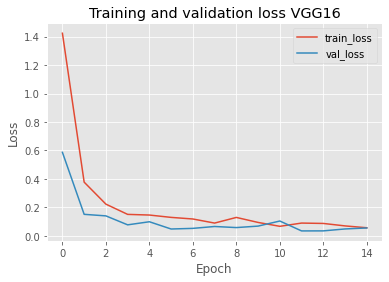

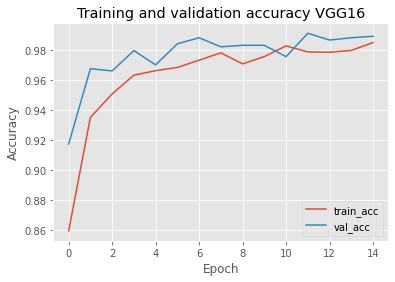

In [12]:
N = np.arange(0, 15)

plt.style.use("ggplot")
plt.figure()
plt.plot(N, hist.history["loss"], label="train_loss")
plt.plot(N, hist.history["val_loss"], label="val_loss")
plt.title("Training and validation loss VGG16")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(os.path.sep.join([config.OUTPUT_PATH, "vgg_losses.png"]))
plt.legend()

plt.figure()
plt.plot(N, hist.history["accuracy"], label="train_acc")
plt.plot(N, hist.history["val_accuracy"], label="val_acc")
plt.title("Training and validation accuracy VGG16")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(os.path.sep.join([config.OUTPUT_PATH, "vgg_accuracy.png"]))
plt.legend()

plt.show()

              precision    recall  f1-score   support

        open      0.977     0.979     0.978       388
       short      0.963     0.963     0.963       301
    mousebit      0.982     0.969     0.976       393
        spur      0.987     0.966     0.977       325
      copper      0.990     0.997     0.993       294
    pin-hole      0.961     0.990     0.975       300

    accuracy                          0.977      2001
   macro avg      0.977     0.978     0.977      2001
weighted avg      0.977     0.977     0.977      2001



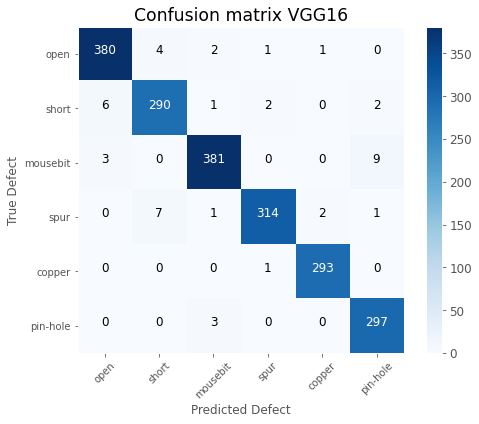

In [17]:
import itertools

predictions = list()
for path in testGen.filepaths:
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    preds = model.predict(image)
    predictions.append(preds.argmax(axis=1))

print(classification_report(testGen.classes,
	predictions, target_names=testGen.class_indices, digits=3))

plt.style.use("ggplot")
plt.grid(False)
plt.rcParams["figure.figsize"] = (8,6)
font = {'size' : 12}
plt.rc('font', **font)

cm = confusion_matrix(testGen.classes, predictions)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(testGen.class_indices))

plt.xticks(tick_marks, testGen.class_indices, rotation=45)
plt.yticks(tick_marks, testGen.class_indices)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Defect')
plt.ylabel('True Defect')
plt.title('Confusion matrix VGG16')
plt.savefig('output/vgg_confusion_matrix.png')
plt.show()